# Librerías y archivos

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

##### FEATURE SELECTION #####
from varclushi import VarClusHi
from sklearn.feature_selection import SelectKBest, f_classif

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
diamonds_data = pd.read_csv('datos/diamonds_data.csv',sep=',')

# Data exploration

## Tipos de datos

In [3]:
diamonds_data.dtypes.to_frame()

,0
carat,float64
cut,object
color,object
clarity,object
depth,float64
table,float64
price,int64
x,float64
y,float64
z,float64


In [4]:
data = diamonds_data.copy()

In [5]:
target = 'price'

In [6]:
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [7]:
data.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [19]:
ls_cat = ['cut', 'color', 'clarity']
ls_cont= list(set(data.columns)-set(ls_cat)-set([target]))

## Outliers

In [20]:
data[ls_cont].describe(percentiles=[0.05,0.95])

,carat,x,z,y,table,depth
count,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000
mean,0.797976,5.731236,3.538776,5.734601,57.457328,61.749325
std,0.474035,1.121807,0.705729,1.142184,2.234578,1.432711
min,0.200000,0.000000,0.000000,0.000000,43.000000,43.000000
5%,0.300000,4.290000,2.650000,4.300000,54.000000,59.300000
50%,0.700000,5.700000,3.530000,5.710000,57.000000,61.800000
95%,1.700000,7.660000,4.730000,7.650000,61.000000,63.800000
max,5.010000,10.740000,31.800000,58.900000,95.000000,79.000000


In [21]:
def get_bounds(x,q_down:float=0.025,q_up:float=0.75,factor:float=1.5):
    '''Obtener intervalo de aceptación para no considerar outliers'''
    q3 = x.quantile(q_up)
    q1 = x.quantile(q_down)
    iqr = q3 - q1
    lb = q1 - factor*iqr
    ub = q3 + factor*iqr
    return pd.Interval(lb, ub, closed="both")

def outliers(df,columnas_continuas:list):
    data = df.copy()
    dc_out = {feat: get_bounds(data[feat]) for feat in columnas_continuas}
    for col in columnas_continuas:
        data[f"ol_{col}"] = data[col].map(lambda x: x not in dc_out[col]).astype(int)
    data["ol"] = data[[x for x in data.columns if x.startswith("ol")]].mean(axis=1)
    data["ol"].describe([0.9, 0.95, 0.96, 0.97, 0.98, 0.99])
    data = data[data["ol"]<=0.3].drop(columns=[x for x in data.columns if x.startswith("ol")])
    return data 

No quitaré outliers


## Unarias & normalización

In [22]:
for var in ls_cat:
    print(data[var].value_counts(1))

Ideal        0.399518
Premium      0.255665
Very Good    0.224031
Good         0.090933
Fair         0.029854
Name: cut, dtype: float64
G    0.209308
E    0.181643
F    0.176915
H    0.153977
D    0.125607
I    0.100501
J    0.052049
Name: color, dtype: float64
SI1     0.242258
VS2     0.227258
SI2     0.170462
VS1     0.151437
VVS2    0.093881
VVS1    0.067773
IF      0.033191
I1      0.013740
Name: clarity, dtype: float64


Mantienen buena proporción en los registros

## Visualizaciones

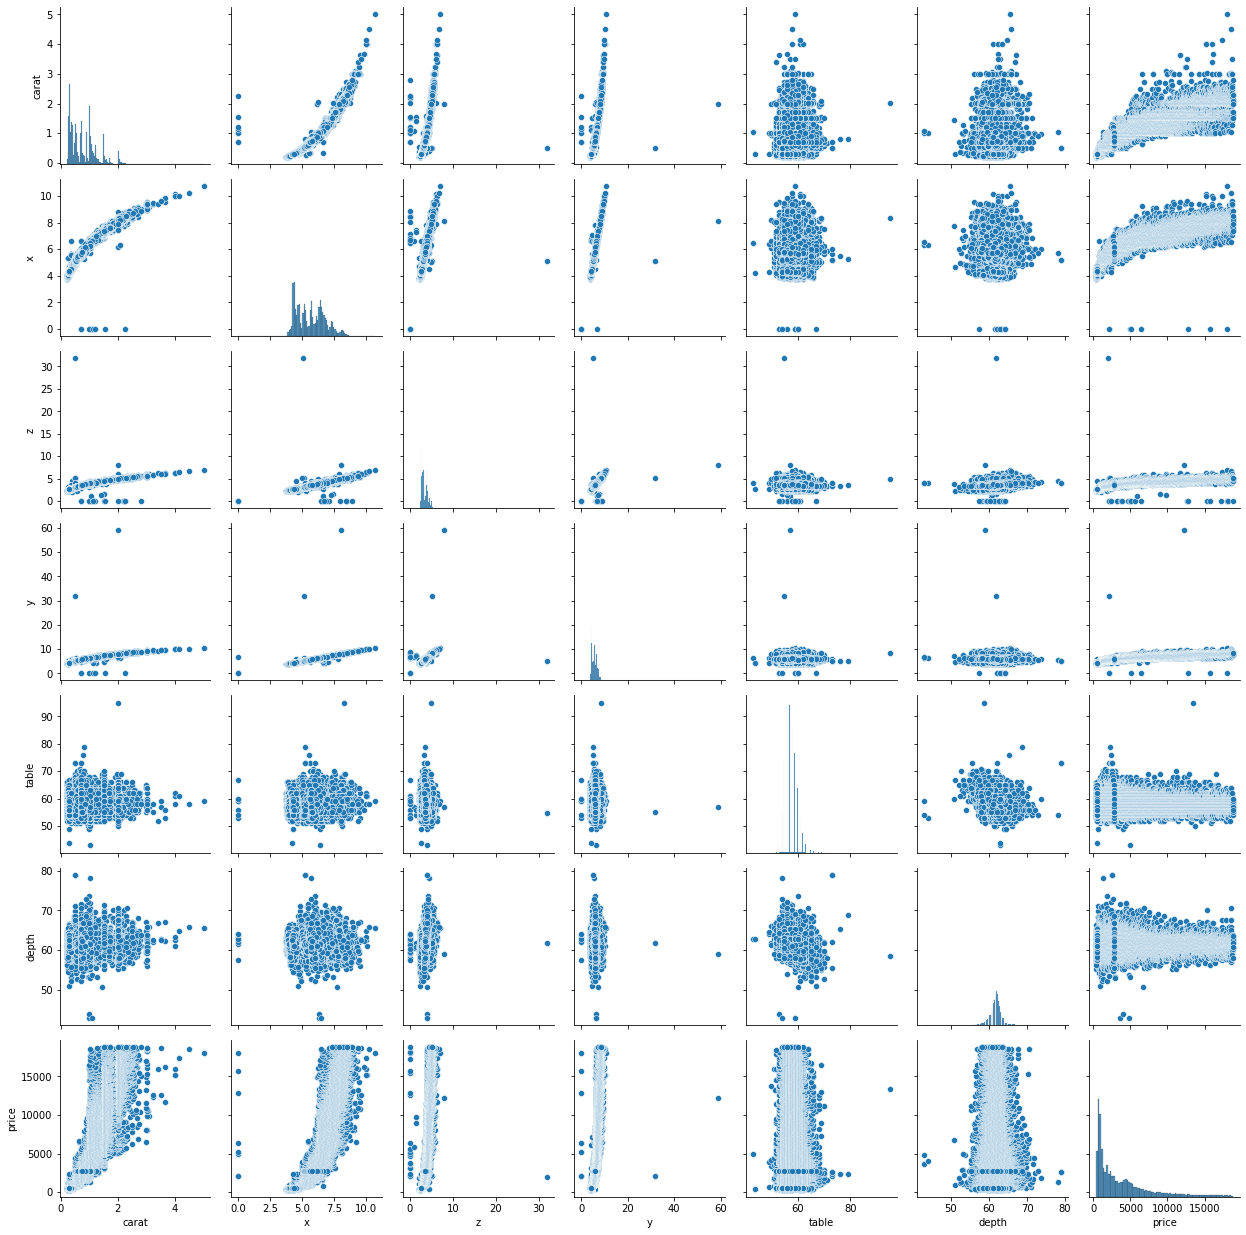

In [23]:
g = sns.PairGrid(data[ls_cont+['price']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

Parece que carat, x, z, y son variables con una correlación alta con price. Veamos si salen en las variables más predictoras con una regresión lineal.

# Feature engineering

In [95]:
data_dummie = pd.get_dummies(data[ls_cat])

In [96]:
data_processing = pd.concat([data,data_dummie],axis=1)

In [97]:
data_processing.drop(columns=ls_cat,inplace=True)

In [98]:
ls_cont = [x for x in data_processing.columns if x!=target]

In [99]:
X = data_processing[ls_cont].copy()
y = data_processing[[target]].copy()

In [100]:
mm = MinMaxScaler()

In [101]:
Xmm = pd.DataFrame(mm.fit_transform(X),columns=ls_cont)

# Feature selection

## Varclushi

In [131]:
n_features = 10

In [132]:
vc = VarClusHi(df=Xmm, feat_list=Xmm.columns,maxclus= n_features)

vc.varclus()

res = vc.rsquare.sort_values(by=["Cluster", "RS_Ratio"]).groupby(["Cluster",'Variable']).first()

res_aux = res.reset_index()

res = vc.rsquare.sort_values(by=["Cluster", "RS_Ratio"]).groupby(["Cluster"]).first()

bf = [x for x in res["Variable"]]

## Select k-best

In [133]:
kb = SelectKBest(k="all")
kb.fit(Xmm, y)
kb_scores = pd.DataFrame({'variable':Xmm.columns,'score':kb.scores_})
kb_scores = kb_scores.sort_values(by='score').reset_index(drop=True).dropna()
bf = [x for x in kb_scores["variable"].tail(n_features)]

/home/abraxas/venv/DIPLOMADO/lib/python3.8/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [135]:
Xv = Xmm[bf].copy()

# Modelos

In [136]:
X_train, X_test, y_train, y_test = train_test_split(Xv, y, test_size=0.3, random_state=777)

In [137]:
def classification_metrics(X, y, model,pipe=None,scores:tuple=('r2')):
    '''Medir performance del modelo'''
    if pipe:
        pipe = Pipeline(pipe.steps + [("model", model)])
    else:
        pipe = Pipeline([("model", model)])
    ls_scores = cross_val_score(estimator=pipe, X=X, y=y, scoring=scores, n_jobs=-1, cv=4)
    print(f"Media: {np.mean(ls_scores):,.2f}, STD: {np.std(ls_scores)}")

In [138]:
linreg = LinearRegression()

In [139]:
classification_metrics(X_train,y_train,linreg)

Media: 0.89, STD: 0.004049164214151659


In [143]:
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [144]:
r2_score(y_test,linreg.predict(X_test))

0.8870600113490669

array([[  -449.26189994],
       [   421.94248437],
       [ -1769.46329421],
       [  -929.04600565],
       [  -296.07896478],
       [ -1786.00297859],
       [  8048.53595245],
       [-33187.3106344 ],
       [ 50753.82068712],
       [ -4673.83796176]])

In [154]:
beta = pd.DataFrame(data=linreg.coef_.reshape(10,1),index=bf,columns=['beta'])

In [156]:
beta.sort_values(by='beta')

,beta
z,-33187.310634
x,-4673.837962
clarity_SI2,-1786.002979
color_J,-1769.463294
clarity_SI1,-929.046006
color_H,-449.261900
clarity_VS2,-296.078965
color_D,421.942484
y,8048.535952
carat,50753.820687
